# Using FastAI for creating a Waste Classifier

Fastai is a deep learning library which provides high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains. 

It has two main design goals: 
1. To be approachable and rapidly productive
2. To be also configurable. 

## Waste Classifier
The aim is to build a model for waste classification that identifies among the different classes: 
- cardboard
- compost
- glass
- metal
- paper
- plastic
- trash

This machine learning model will help people to improve their decision when classifying trash   

## Imports

In [1]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

from fastai.vision.data import ImageDataLoaders

import warnings
warnings.filterwarnings('ignore')

from os import listdir
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


## Load the data

The data is already splitted in train and test folders. Inside each folder contains one folder for each class. Those images were obtained using Bing searcher using the api HTTP.   
Those images have been manually cleaned, removing the ones that were not useful or were in the wrong category. 
The data has been divided into two sets train and test sets.  

In [2]:
BASE_DIR = "/Users/mika/Projects/fastai-waste-classifier"
DATASET_DIR = f"{BASE_DIR}/dataset_splits"
TEST_PHOTOS_DIR = f"{BASE_DIR}/test-photos"

In [3]:
!ls $DATASET_DIR

test  train


In [4]:
!ls $DATASET_DIR/train/glass

Glass635.jpg  glass243.jpg  glass491.jpg  glass730.jpeg glass752.jpg
glass11.jpg   glass25.jpg   glass52.jpg   glass731.jpg  glass753.png
glass111.jpg  glass26.jpg   glass65.jpg   glass732.jpeg glass754.jpeg
glass118.jpg  glass28.jpg   glass68.jpg   glass733.jpeg glass757.jpg
glass121.jpg  glass29.jpg   glass7.jpg    glass735.jpg  glass758.jpg
glass151.jpg  glass30.jpg   glass70.jpg   glass738.jpg  glass759.jpg
glass166.jpg  glass31.jpg   glass713.png  glass739.jpeg glass760.jpg
glass19.jpg   glass33.jpg   glass715.jpg  glass740.jpg  glass761.jpg
glass20.jpg   glass331.jpg  glass716.jpg  glass743.png  glass763.jpg
glass21.jpg   glass34.jpg   glass717.jpg  glass744.png  glass764.jpg
glass215.jpg  glass35.jpg   glass72.jpg   glass745.jpg  glass766.jpg
glass22.jpg   glass360.jpg  glass721.jpg  glass746.jpg  glass767.jpg
glass239.jpg  glass395.jpg  glass724.jpg  glass747.jpg  glass78.jpg
glass240.jpg  glass42.jpg   glass725.png  glass748.jpg  glass8.jpg
glass241.jpg  glass421.jpg  glass726

## Data augmentation

Apply data augmentation to the training data, keeping 10% the for validation set. Data augmentation process apply some transformations (flip, rotate) to the original images to generate more data to train the model. Plus, helps to avoid overfitting, making the training set less specific. 

The validation set is used to track the model error while training. 


In [5]:
data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='train',
    shuffle=True,
    valid_pct=0.1,
    item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
    batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
)

Let's show some of the data for the validation and training sets.

In [6]:
data.valid_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash/trash92.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/glass/glass735.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/test/cardboard/cardboard138.jpg')]

In [7]:
data.train_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/compost/compost513.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/compost/compost667.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/compost/compost206.jpg')]

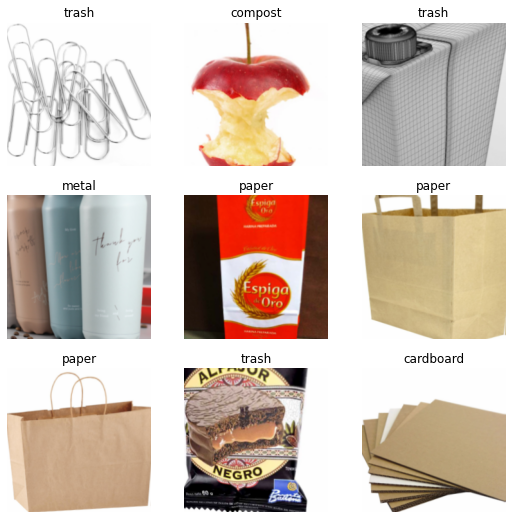

In [8]:
data.train.show_batch()

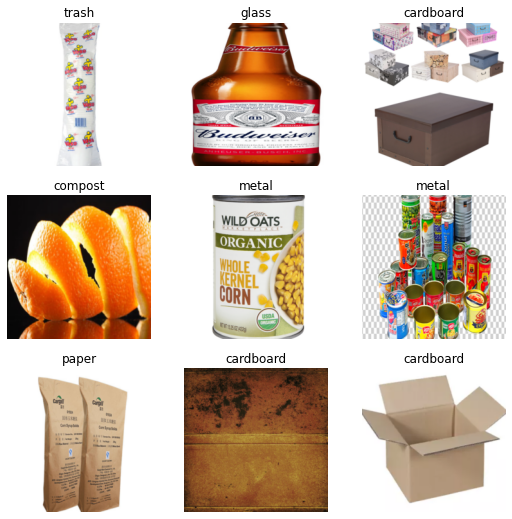

In [9]:
data.valid.show_batch()

In [10]:
data.vocab

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Training the model using resnet50

ResNet34 is a convolutional neural network(CNN) that has 34 layers. It has been already trained with images from the ImageNet database. It classifies 1000 object from very broad categories, such as pencil or animals. The input size of the network is 224x224. 

This network can be reused to train other model. 

In [12]:
learn = cnn_learner(data, resnet50, metrics=accuracy)
learn.fine_tune(20)
learn.export(fname=f'{BASE_DIR}/result-resnet34.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,1.151935,0.462112,0.877076,13:56


epoch,train_loss,valid_loss,accuracy,time
0,0.551661,0.334733,0.880399,17:50
1,0.444920,0.343560,0.890365,15:55
2,0.377446,0.337244,0.900332,15:52
3,0.306475,0.371290,0.877076,16:54
4,0.298967,0.417597,0.893688,18:18
5,0.266408,0.332281,0.903654,17:40
6,0.253800,0.302368,0.923588,16:57
7,0.223675,0.290698,0.903654,17:24
8,0.204125,0.236864,0.936877,17:08
9,0.164178,0.241989,0.923588,15:28


## Metrics
Now, let's calculate the accuracy metric for the test set. 
The test set refers to a group of data that has been separated form the training data and the model does not know. 
It contains original images without any transformation. It will reflect how well the model will behave in the real life, when classifying new images.

Let's see what is the result for some photos that we took with the cellphone and check what is the output of the model. 

In [11]:
import utils 

We can see that has good accuracy, so we decided to use this model for our final solution

Accuracy 0.9818481848184818
F1 score 0.9825126711801634
              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99        81
     compost       0.99      1.00      0.99       152
       glass       1.00      1.00      1.00        20
       metal       0.95      0.98      0.97        57
       paper       0.98      0.97      0.98       112
     plastic       1.00      0.96      0.98        50
       trash       0.98      0.97      0.97       134

    accuracy                           0.98       606
   macro avg       0.98      0.98      0.98       606
weighted avg       0.98      0.98      0.98       606



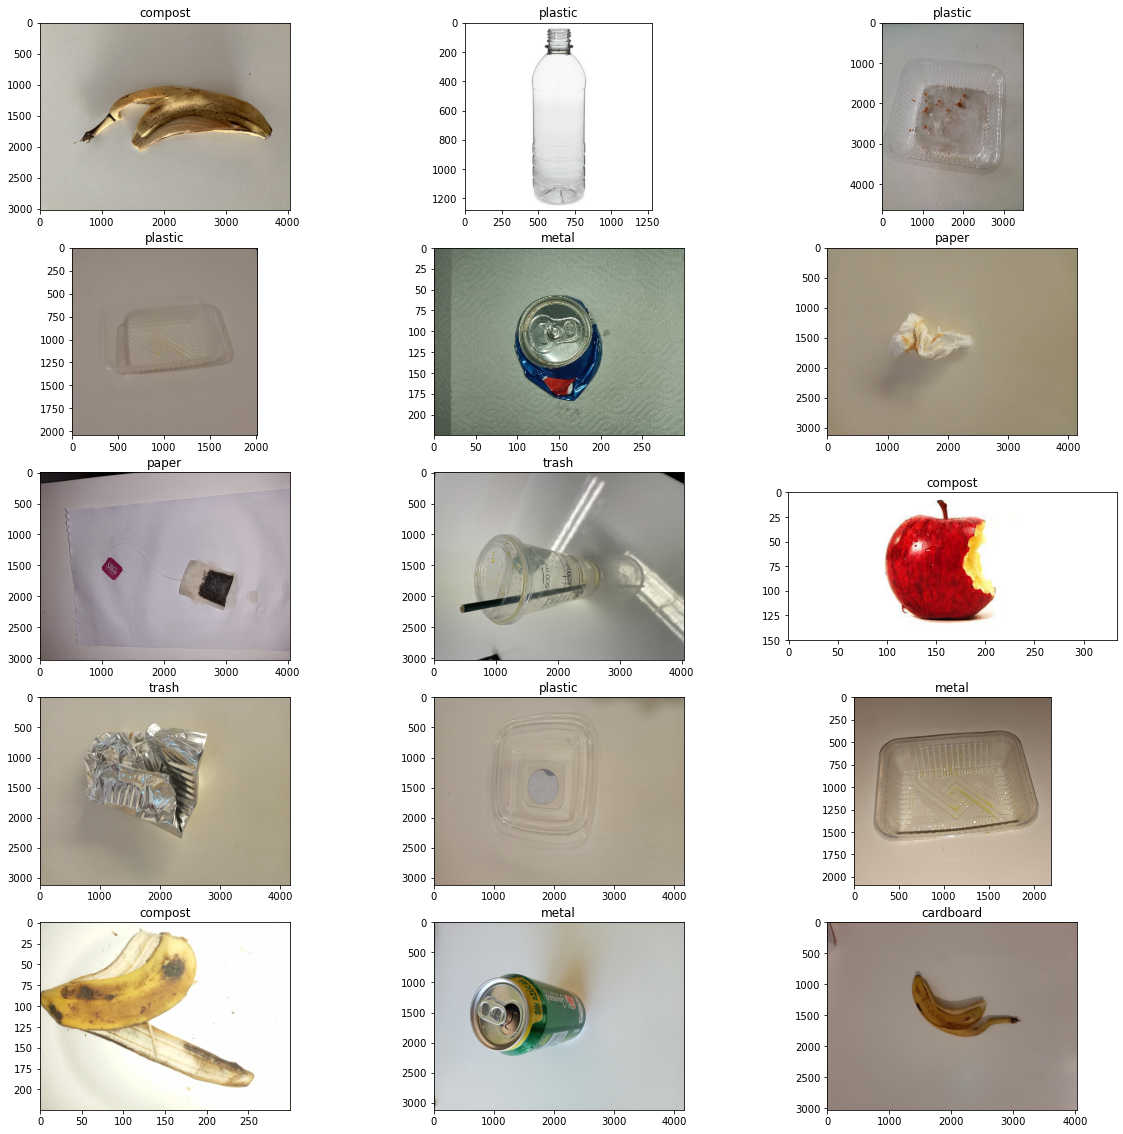

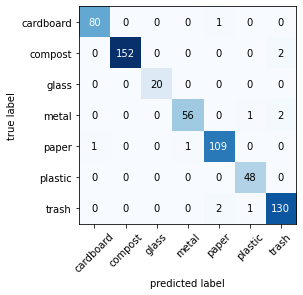

In [13]:
learn_loaded = load_learner(f'{BASE_DIR}/result-resnet34.pkl')
utils.show_predictions(learn_loaded, TEST_PHOTOS_DIR)                      
utils.print_results(data.vocab, learn_loaded, f"{DATASET_DIR}/test", 'classification_matrix_resnet34.png')